In [296]:
using Symbolics
using Plots

#custom dependencies
include("integration.jl")
include("derivatives.jl")
include("error_metrics.jl")
include("interpolations.jl")
include("initial_value_problems.jl")
include("root_finding_algorithms.jl")

bisection (generic function with 1 method)

-------------------

# 1. Numeric differenciation 

### a. Using three and five points differenciation formula, find the value of the derivative of:

#### i) y = $tan(\frac{x}{3})$ at x = 3, with a step size of h = 0.1

In [297]:
function f1(x)
    return tan(x/3)
end

f1 (generic function with 1 method)

In [298]:
x1 = 3.0
h1 = 0.1

df1_3 = three_point_numeric_diff_middle(f1, x1, h1)
df1_5 = five_point_numeric_diff_middle(f1, x1, h1)

# print results
println("First function")
println("3 point numeric diff: ", df1_3)
println("5 point numeric diff: ", df1_5)
println("Difference between both:", error_metric(df1_3, df1_5, true))

First function
3 point numeric diff: 1.1453517333306606
5 point numeric diff: 1.1417911815759805
Difference between both:0.0035605517546801746


#### ii) y = $e^{x} + x$ at x = 2, with a step size of h = 0.2

In [299]:
function f2(x)
    return exp(x) + x
end

f2 (generic function with 1 method)

In [300]:
x2 = 2.0
h2 = 0.2

df2_3 = three_point_numeric_diff_middle(f2, x2, h2)
df2_5 = five_point_numeric_diff_middle(f2, x2, h2)

println("Second function")
println("3 point numeric diff: ", df2_3)
println("5 point numeric diff: ", df2_5)
println("Difference between both:", error_metric(df2_3, df2_5, true))

Second function
3 point numeric diff: 8.438415087552942
5 point numeric diff: 8.388660134967886
Difference between both:0.049754952585056245


### b. Calculate first derivative of $y = cos(x)$ with $x = \frac{\pi}{4}$ using the Richardson extrapolation method with a step size of $h_{1} = \frac{\pi}{3}$ and $h_{2} = \frac{\pi}{6}$. Using the three middle points formula for inferring the derivative inside the Richardson extrapolation method.

In [301]:
function f3(x)
    return cos(x)
end

f3 (generic function with 1 method)

In [302]:
x3 = pi/4
h3_1 = pi/3
h3_2 = pi/6

#richardson depth
ndepth = 5

approx1 = general_richardson(f3, x3, h3_1, ndepth, three_point_numeric_diff_middle)
approx2 = general_richardson(f3, x3, h3_2, ndepth, three_point_numeric_diff_middle)
println("\n===========Richardson extrapolation =======")
println("Approximation h1: ", approx1)
println("Approximation h2: ", approx2)
println("Difference between both:", error_metric(approx1, approx2, true))


===========Richardson extrapolation =======
Approximation h1: -0.7071067811865213
Approximation h2: -0.7071067811865469
Difference between both:2.5646151868841116e-14


### c. Determine the inflection points of the normal distribution function defined as follows:

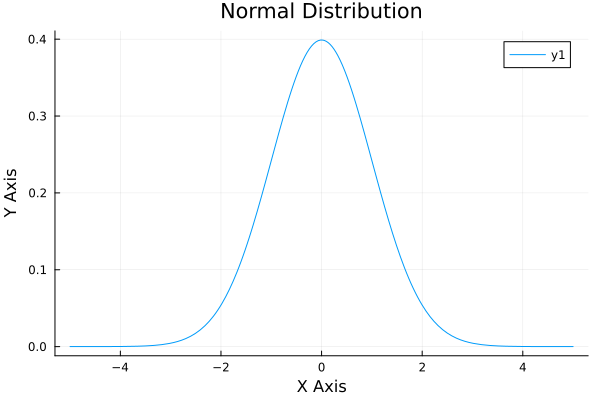

In [303]:
function normal_distribution(x)
    return (1/sqrt(2*pi))*exp(-x^2/2)
end

plot(normal_distribution, legend=true, title="Normal Distribution", xlabel="X Axis", ylabel="Y Axis")

We built functions to get the nth-derivative of a function by interpolating the sampled points from the function _(with cubic splines and cubic lagrange polynomials)_ and then derivating the interpolating function.


1. First sample the original function as follows:

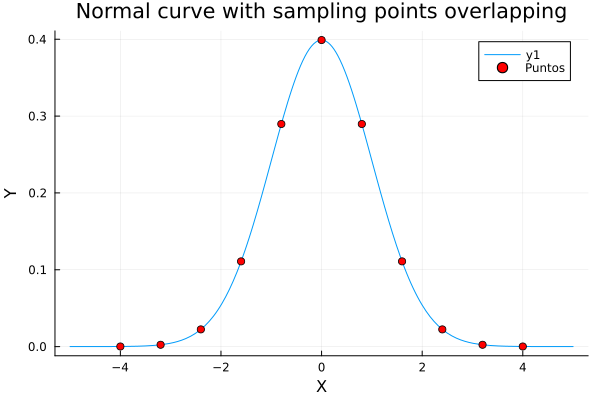

In [304]:
step = 0.8
start = -4
stop = 4

x_sample = [i for i in start:step:stop]
y_sample = [normal_distribution(x) for x in x_sample]
sampled_points = [[x, y] for (x, y) in zip(x_sample, y_sample)]


plot(normal_distribution,
     title="Normal curve with sampling points overlapping",
     xlabel="X",
     ylabel="Y",
     legend=true)

scatter!(x_sample,
         y_sample,
         label="Puntos",
         color=:red)   


2. Now built functions to get the nth-derivative of a function by interpolating the sampled points from the function (with cubic splines and cubic lagrange polynomials).

In [305]:
function get_nth_derivarive_lagrange(sampling_points::Vector{Vector{Float64}},
                                     numeric_diff_algoritm::Function,
                                     fn::Function,
                                     n::Int,
                                     nresample::Int,
                                     h::Float64, 
                                     niters::Int)
    """
        Given a set of points, this function calculates the nth derivative of the function that interpolates the points.

        Arguments:
        ----------------
            sampling_points: Vector of points [x,y] to interpolate.
            numeric_diff_algoritm: function used to calculate the derivative.
            fn: assistant function to calculate the derivative, some algorithms need an extra function to calculate the derivative.

            n: nth derivative to calculate.
            h: step to calculate the derivative.
        
        Returns:
        ----------------
            y: interpolated value.
    """

    if n < 1
        error("The nth derivative must be greater than 0")
    end

    xmin = minimum([p[1] for p in sampling_points])
    xmax = maximum([p[1] for p in sampling_points])
    #println("sampling_points: ", sampling_points)
    
    for i in 1:n
        
        #interpolate the points
        fn = (x) -> interpolate_point(sampling_points, x)
        
        #build the x x_domain to sample the points
        x_domain = [x for x in range(start=xmin, stop=xmax, length=nresample)] 
        #println("x_domain: ", x_domain)

        #resample the points 
        sampling_points = [[x, fn(x)] for x in x_domain]
        #println("sampling_points1: ", sampling_points)

        #calculate the derivative of the points
        derivarives::Vector{Vector{Float64}} = []

        for j in 1:length(x_domain)
        
            x = x_domain[j]

            #if the point + h is greater than the maximum x value then use the three point method
            #to avoid the error of the points being out of the domain
            if x + h > xmax
                #computes the derivative of the last points
                last_3_points = sampling_points[j-2:j]
                push!(derivarives, [x, three_point_numeric_diff_extremes(last_3_points, h)])
                println(j)

            #if the point - h is less than the minimum x value then use the richardson method
            #which is more accurate
            else
                push!(derivarives, [x, numeric_diff_algoritm(fn, x, h, niters)])
            end
        
        end
        sampling_points = derivarives

        #println("sampling_points2: ", sampling_points)
    end

    return sampling_points
    
end

get_nth_derivarive_lagrange (generic function with 1 method)

In [306]:
function get_nth_derivarive_cubic(sampling_points::Vector{Vector{Float64}},
                                  numeric_diff_algoritm::Function,
                                  fn::Function,
                                  n::Int,
                                  h::Float64, 
                                  nresample::Int, 
                                  niters::Int)
    """
        Given a set of points, this function calculates the nth derivative of the function that interpolates the points.

        Arguments:
        ----------------
            sampling_points: Vector of points [x,y] to interpolate.
            numeric_diff_algoritm: function used to calculate the derivative.
            fn: assistant function to calculate the derivative, some algorithms need an extra function to calculate the derivative.

            n: nth derivative to calculate.
            h: step to calculate the derivative.
        
        Returns:
        ----------------
            y: interpolated value.
    """

    if n < 1
        error("The nth derivative must be greater than 0")
    end

    @variables x_sym
    xmin = minimum([p[1] for p in sampling_points])
    xmax = maximum([p[1] for p in sampling_points])
    
    for i in 1:n
        #given the points try to approximate the function with a cubic spline
        polynomials = build_cubic_splines(sampling_points, x_sym)
        fn = (x) -> interpolate(polynomials, x)
        
        #build the x_domain to sample the points
        x_domain = [x for x in range(start=xmin, stop=xmax, length=nresample)]
        
        #resample the points to get a better approximation using the cubic spline
        #update the sampling_points
        sampling_points = [[x, fn(x)] for x in x_domain]
    
        #calculate the derivative of the points
        derivative::Vector{Vector{Float64}} = []
    
        for j in 1:length(x_domain)

            x = x_domain[j]
            if x + h > xmax
                #computes the derivative of the last points
                last_3_points = sampling_points[j-2:j]
                push!(derivative, [x, three_point_numeric_diff_extremes(last_3_points, h)])
            else
                push!(derivative, [x, numeric_diff_algoritm(fn, x, h, niters)])
            end
        end

        sampling_points = derivative
    end

    return sampling_points, build_cubic_splines(sampling_points, x_sym)
end

get_nth_derivarive_cubic (generic function with 1 method)

3. Obtain the nth-derivative of the normal distribution function, with n = 2, using the functions built in the previous step, particularly with the cubic lagrange polynomials.

20
20


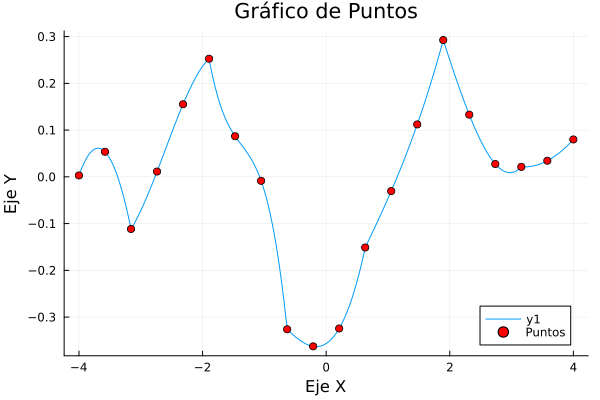

In [307]:
#degree of the derivative
n = 2
h = 0.25
nresample = 20
niters = 5

nth_derivative = get_nth_derivarive_lagrange(sampled_points, richardson, normal_distribution, n, nresample, h, niters)
nth_derivative_x = [nth_derivative[i][1] for i in 1:length(nth_derivative)]
nth_derivative_y = [nth_derivative[i][2] for i in 1:length(nth_derivative)]

plot_polynomiun(nth_derivative_x, nth_derivative_y, 0.025)


4. Obtain the nth-derivative of the normal distribution function, with n = 2, using the functions built in the previous step, particularly with the cubic splines.

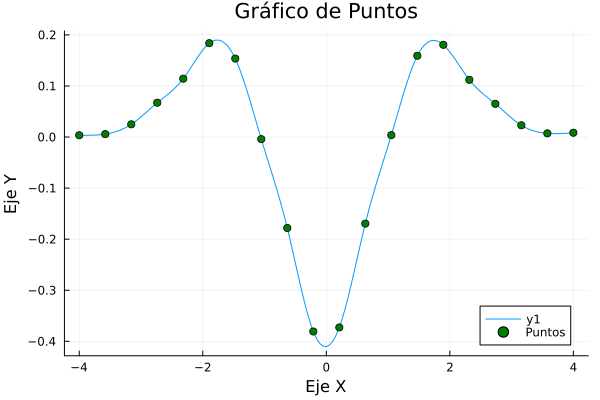

In [308]:
#degree of the derivative
n = 2
h = 0.25
resample = 20
niters = 5

nth_derivative, polynomials = get_nth_derivarive_cubic(sampled_points, richardson, normal_distribution, n, h, resample, niters)
nth_derivative_x = [nth_derivative[i][1] for i in 1:length(nth_derivative)]
nth_derivative_y = [nth_derivative[i][2] for i in 1:length(nth_derivative)]

#used for plotting the interpolation of the points given by the get_nth_derivarive_cubic function
x_domain = [i for i in start:0.05:stop]
y_range  = [interpolate(polynomials, x) for x in x_domain]

plot(x_domain, y_range, legend=true, title="Gráfico de Puntos", xlabel="Eje X", ylabel="Eje Y")
scatter!(nth_derivative_x, nth_derivative_y, label="Puntos", color=:green)

5. Using the cubic splines, find the inflection points of the normal distribution function by bisection method, 
over the interval.

In [309]:
fn = (x) -> interpolate(polynomials, x)
low = -2.0
high = 2.0
tol = 0.0001
max_iter = 100
target_value = 0.0

x1, niters1 = bisection(fn, low, high, tol, max_iter, target_value)

(-1.06298828125, 13)

In [310]:
low = 0.0
high = 2.0
tol = 0.0001
max_iter = 100
target_value = 0.0

x2, niters2 = bisection(fn, low, high, tol, max_iter, target_value)

(1.04345703125, 12)

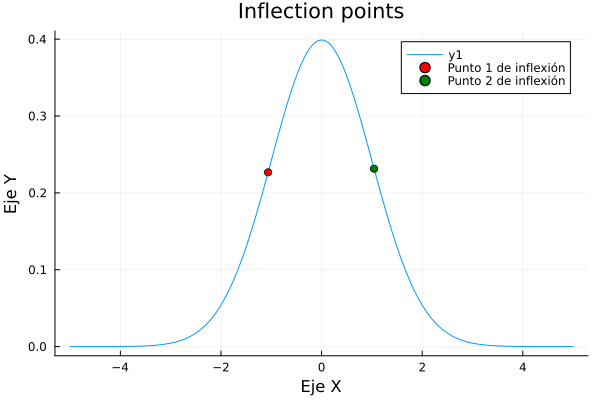

In [311]:
plot(normal_distribution, legend=true, title="Inflection points", xlabel="Eje X", ylabel="Eje Y")
scatter!([x1], [normal_distribution(x1)], label="Punto 1 de inflexión", color=:red)
scatter!([x2], [normal_distribution(x2)], label="Punto 2 de inflexión", color=:green)

-----------
# 2. Numerical integration

### a.

#### i. Analytic integration

In [312]:
f4 = x -> 6 + 3*cos(x)
int_f4 = x -> 6*x + 3*sin(x)

start = 0.0
stop = π/2
exact_value = int_f4(stop) - int_f4(start)
print("The exact value of the integral between  [$(start), $(stop)] is: ", exact_value)


The exact value of the integral between  [0.0, 1.5707963267948966] is: 12.42477796076938

#### ii. Trapezoidal rule, with only one application

In [313]:
trapezoidal_approx_f = trapezoidal_approx(f4, start, stop)
abs_error = error_metric(trapezoidal_approx_f, exact_value, true)
relative_error = error_metric(trapezoidal_approx_f, exact_value, false)

print("\nThe trapezoidal approximation of the integral of f between [$(start), $(stop)] is: ", trapezoidal_approx_f)
print("\nThe absolute error of the trapezoidal approximation is: ", abs_error)
print("\nThe relative error of the trapezoidal approximation is: $(relative_error)%")



The trapezoidal approximation of the integral of f between [0.0, 1.5707963267948966] is: 11.780972450961723
The absolute error of the trapezoidal approximation is: 0.643805509807656
The relative error of the trapezoidal approximation is: 0.0518162587565299%

#### iii. Multiple application of the trapezoidal rule, with $n=2$ and $n=4$

In [314]:
n = 2

trapezoidal_composite_f = trapezoidal_composite(f4, start, stop, n)
abs_error = error_metric(trapezoidal_composite_f, exact_value, true)
relative_error = error_metric(trapezoidal_composite_f, exact_value, false)

print("\nThe trapezoidal composite n = $(n), approximation of the integral of f between [$(start), $(stop)] is: ", trapezoidal_composite_f)
print("\nThe absolute error of the trapezoidal composite approximation is: ", abs_error)
print("\nThe relative error of the trapezoidal composite approximation is: $(relative_error)%")


The trapezoidal composite n = 2, approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.268956307674939
The absolute error of the trapezoidal composite approximation is: 0.1558216530944403
The relative error of the trapezoidal composite approximation is: 0.012541202232059151%

In [315]:
n = 4

trapezoidal_composite_f = trapezoidal_composite(f4, start, stop, n)
abs_error = error_metric(trapezoidal_composite_f, exact_value, true)
relative_error = error_metric(trapezoidal_composite_f, exact_value, false)

print("\nThe trapezoidal composite n = $(n), approximation of the integral of f between [$(start), $(stop)] is: ", trapezoidal_composite_f)
print("\nThe absolute error of the trapezoidal composite approximation is: ", abs_error)
print("\nThe relative error of the trapezoidal composite approximation is: $(relative_error)%")


The trapezoidal composite n = 4, approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.386125363687706
The absolute error of the trapezoidal composite approximation is: 0.03865259708167379
The relative error of the trapezoidal composite approximation is: 0.003110928597977159%

#### iv. 1/3 Simpson's rule, with only one application.

In [316]:
simpson_rule_approx_f = simpson_rule_approx(f4, start, stop)
abs_error = error_metric(simpson_rule_approx_f, exact_value, true)
relative_error = error_metric(simpson_rule_approx_f, exact_value, false)

print("\nThe simpson rule approximation of the integral of f between [$(start), $(stop)] is: ", simpson_rule_approx_f)
print("\nThe absolute error of the simpson rule approximation is: ", abs_error)
print("\nThe relative error of the simpson rule approximation is: $(relative_error)%")


The simpson rule approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.43161759324601
The absolute error of the simpson rule approximation is: 0.006839632476630442
The relative error of the simpson rule approximation is: 0.0005504832760976689%

#### v. Multiple application of the 1/3 Simpson's rule, with $n=4$

In [317]:
n = 4

simpson_composite_f = simpson_composite(f4, start, stop, n)
abs_error = error_metric(simpson_composite_f, exact_value, true)
relative_error = error_metric(simpson_composite_f, exact_value, false)

print("\nThe simpson composite n = $(n), approximation of the integral of f between [$(start), $(stop)] is: ", simpson_composite_f)
print("\nThe absolute error of the simpson composite approximation is: ", abs_error)
print("\nThe relative error of the simpson composite approximation is: $(relative_error)%")



The simpson composite n = 4, approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.425181715691961
The absolute error of the simpson composite approximation is: 0.00040375492258171164
The relative error of the simpson composite approximation is: 3.249594671683854e-5%

#### vi. 3/8 Simpson's rule, with only one application.

In [318]:
simpson_fraction_rule_approx_f = simpson_fraction_rule_approx(f4, start, stop)
abs_error = error_metric(simpson_fraction_rule_approx_f, exact_value, true)
relative_error = error_metric(simpson_fraction_rule_approx_f, exact_value, false)

print("\nThe simpson fraction rule approximation of the integral of f between [$(start), $(stop)] is: ", simpson_fraction_rule_approx_f)
print("\nThe absolute error of the simpson fraction rule approximation is: ", abs_error)
print("\nThe relative error of the simpson fraction rule approximation is: $(relative_error)%")


The simpson fraction rule approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.427792730712216
The absolute error of the simpson fraction rule approximation is: 0.0030147699428368924
The relative error of the simpson fraction rule approximation is: 0.0002426417560423115%

#### vii. Multiple application of the 3/8 Simpson's rule, with $n=6$

In [319]:
n = 6

simpson_fraction_composite_f = simpson_fraction_composite(f4, start, stop, n)
abs_error = error_metric(simpson_fraction_composite_f, exact_value, true)
relative_error = error_metric(simpson_fraction_composite_f, exact_value, false)

print("\nThe simpson fraction composite n = $(n), approximation of the integral of f between [$(start), $(stop)] is: ", simpson_fraction_composite_f)
print("\nThe absolute error of the simpson fraction composite approximation is: ", abs_error)
print("\nThe relative error of the simpson fraction composite approximation is: $(relative_error)%")


The simpson fraction composite n = 6, approximation of the integral of f between [0.0, 1.5707963267948966] is: 12.42478013952675
The absolute error of the simpson fraction composite approximation is: 2.1787573700748908e-6
The relative error of the simpson fraction composite approximation is: 1.7535583951312525e-7%

### b. 

#### i. Analytic integration, get the exact value of the integral

In [320]:
qt = t -> 9 + 5*(cos(0.4)^2)*t
ct = t -> (5*exp(-0.5*t)) + 2*exp(0.15*t)
mt = t -> qt(t)*ct(t)

#1199 (generic function with 1 method)

In [321]:
mt_int = t -> exp(-0.5*t)*(-42.4177*t + exp(0.65*t)*(56.5569*t - 257.046) - 174.835)

#1201 (generic function with 1 method)

In [322]:
start_t = 2.0 
end_t = 8.0
exact_value = mt_int(end_t) - mt_int(start_t)

println("The exact value of the integral between  [$(start_t), $(end_t)] is: ", exact_value)

The exact value of the integral between  [2.0, 8.0] is: 929.1794683523293


#### ii. Romberg integration, for finding the value of the integral with tolerance of $0.1\%$

In [323]:
n = 1
romberg_approx_mt = romberg_approx(mt, start_t, end_t, n)
abs_error = error_metric(romberg_approx_mt, exact_value, true)
relative_error = error_metric(romberg_approx_mt, exact_value, false)

print("\nThe romberg approximation of the integral of mt between [$(start_t), $(end_t)] is: ", romberg_approx_mt)
print("\nThe absolute error of the romberg approximation is: ", abs_error)
print("\nThe relative error of the romberg approximation is: $(relative_error)%")


The romberg approximation of the integral of mt between [2.0, 8.0] is: 929.594943800041
The absolute error of the romberg approximation is: 0.41547544771174216
The relative error of the romberg approximation is: 0.0004471423033576984%

### c.

In [324]:
g = 9.81 #m/s^2
c = 10.0 #kg/s
start_t = 0.0 #s
end_t = 8.0 #s
m = 80 #kg

80

In [325]:
vt = t -> (g*m/c)*(1 - exp(-(c/m)*t))
xt = t -> (m*g) * (m * exp(-(c/m)*t) + c*t)/c^2

exact_value = xt(end_t) - xt(start_t)
println("The exact value of the integral between  [$(start_t), $(end_t)] is: ", exact_value)

The exact value of the integral between  [0.0, 8.0] is: 230.96942834507843


In [326]:
n = 1
romberg_approx_xt = romberg_approx(vt, start_t, end_t, n)

print("\nThe romberg approximation of the integral of vt between [$(start_t), $(end_t)] is: ", romberg_approx_xt)
print("\nThe absolute error of the romberg approximation is: ", abs_error)
print("\nThe relative error of the romberg approximation is: $(relative_error)%")


The romberg approximation of the integral of vt between [0.0, 8.0] is: 230.83562234650046
The absolute error of the romberg approximation is: 0.41547544771174216
The relative error of the romberg approximation is: 0.0004471423033576984%

--------
# 3. Solving Initial Value Problems

In [327]:
k = 0.06
y′ = (x, y) -> -k*sqrt(y)

#1207 (generic function with 1 method)

[[0.25, 2.9740754878867066], [0.5, 2.948263475773415], [0.75, 2.922563963660126], [1.0, 2.896976951546839], [1.25, 2.8715024394335544], [1.5, 2.846140427320272], [1.75, 2.820890915206992], [2.0, 2.795753903093714], [2.25, 2.7707293909804385], [2.5, 2.7458173788671654], [2.75, 2.721017866753895], [3.0, 2.6963308546406273], [3.25, 2.671756342527362], [3.5, 2.6472943304140992], [3.75, 2.622944818300839], [4.0, 2.5987078061875817], [4.25, 2.574583294074327], [4.5, 2.5505712819610755], [4.75, 2.5266717698478267], [5.0, 2.5028847577345807], [5.25, 2.4792102456213376], [5.5, 2.455648233508098], [5.75, 2.432198721394861], [6.0, 2.408861709281627], [6.25, 2.3856371971683967], [6.5, 2.3625251850551696], [6.75, 2.339525672941946], [7.0, 2.3166386608287253], [7.25, 2.293864148715508], [7.5, 2.2712021366022945], [7.75, 2.2486526244890848], [8.0, 2.2262156123758787], [8.25, 2.2038911002626764], [8.5, 2.181679088149478], [8.75, 2.159579576036283], [9.0, 2.1375925639230924], [9.25, 2.115718051809906],

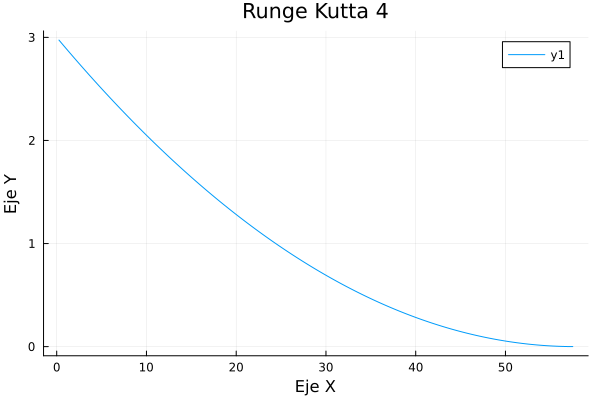

In [328]:
start_t = 0.0
initial_volume = 3.0
step_size = 0.25
tol = 0.0002

solution1 = runge_kutta_4(y′, start_t, initial_volume, step_size, tol)
x_solution1 = [solution1[i][1] for i in 1:length(solution1)]
y_solution1 = [solution1[i][2] for i in 1:length(solution1)]

print(solution1)

plot(x_solution1, y_solution1, legend=true, title="Runge Kutta 4", xlabel="Eje X", ylabel="Eje Y")

Cubic spline interpolation of the solution

In [330]:
@variables t_sym
polynomials2 = build_cubic_splines(solution1, t_sym)
fn2 = (t) -> interpolate(polynomials2, t)

#1213 (generic function with 1 method)

Bisection method for finding the roots of the solution

In [361]:
high = maximum(x_solution1)
low = high - 0.5
tol = 0.001
max_iter = 1000
target_value = 0.0

x1, niters1 = bisection(fn2, low, high, tol, max_iter, target_value)

(57.25, 1)

In [362]:
fn2(57.25)

0.0002120625270833898